# Energy Flow Network (EFN)

Documentation:[1810.05165](https://arxiv.org/abs/1810.05165)
The [`EFN`](https://energyflow.network/docs/archs/#efn) class is used to construct the network architecture.

In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function
# standard numerical library imports
import numpy as np

## Dataset: [Quark and Gluon Jets](https://github.com/pkomiske/EnergyFlow/blob/master/energyflow/datasets/qg_jets.py)
- Pythia 8.226 quark (uds) and gluon jets.
- Pythia 8.235 quark (udscb) and gluon jets.
- Herwig 7.1.4 quark (uds) and gluon jets.
- Herwig 7.1.4 quark (udscb) and gluon jets

The particles are given as `(pt,y,phi,pid)` values, where `pid` is the [PDG id](http://pdg.lbl.gov/2018/reviews/rpp2018-rev-monte-carlo-numbering.pdf)

The samples are generated from $q\bar q\to Z(\to\nu\bar\nu)+g$ and
$qg\to Z(\to\nu\bar\nu)+(uds[cb])$.
Particles are clustered into $R=0.4$
anti-$k_T$ jets with transverse momentum
$p_T\in[500,550]$ GeV and rapidity $|y|<1.7$ are kept. 

In [2]:
# energyflow imports
import energyflow as ef
from energyflow.archs import EFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

[Classification metric from sklearn](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics)

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
def foo():
    """lol"""
    pass
bar = foo
bar._doc_ = ':)'

In [7]:
foo._doc_

':)'

## Network settings

From [1810.05165](https://arxiv.org/abs/1810.05165):
"For all quark/gluon models, one million jets were used for training, 200k for validation
(except for the EFPs, which did not use validation), and 200k for testing."


In [9]:
# data controls, can go up to 2000000 total for full dataset
# train, val, test = 1000000, 200000, 200000
train, val, test = 75000, 10000, 15000

In [10]:
print("Number of total data used:",train + val + test)

Number of total data used: 100000


* Phi_sizes : The sizes of the dense layers in the per-particle frontend module $\Phi$. The last element will be the number of latent observables that the model defines. Larger latent space dimensions correspond roughly to higher resolution images.
* F_sizes : The sizes of the dense layers in the backend module $F$.

In [11]:
# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

In [48]:
# network training parameters
num_epoch = 20 #54 in the paper for EFN
batch_size = 128 #500

In [15]:
## let's just take one gpu:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Load dataset

Each dataset consists of two components:
- `X` : a three-dimensional numpy array of the jets with shape 
`(num_data,max_num_particles,4)`.
- `y` : a numpy array of quark/gluon jet labels (quark=`1` and gluon=`0`).

In [16]:
# load data

#jets are padded with zero-particles in order to make a contiguous array.
# PDG id taken out
#X, y = qg_jets.load(train + val + test, pad=False, ncol=3)

X, y = qg_jets.load(train + val + test)

In [18]:
print("Total number of events?: ",len(X))
print("Number of jets in the event 6: ", len(X[6]))
print("pt,y,phi of the jet 0 in the event 6:", (X[6][14]))

Total number of events?:  100000
Number of jets in the event 6:  139
pt,y,phi of the jet 0 in the event 6: [ 3.75542939e+01 -7.33788160e-01  5.46960605e+00 -2.11200000e+03]


In [25]:
# ignore pid information 
X = X[:,:,:3]

In [21]:
# convert labels to categorical
Y = to_categorical(y, num_classes=2)

In [22]:
print("this is the initial y with 1(quark) and 0(gluon):", y)
print("this is the converted to categorical Y :", Y)

this is the initial y with 1(quark) and 0(gluon): [1. 1. 1. ... 1. 0. 0.]
this is the converted to categorical Y : [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [26]:
#####Trying to undestand 'to_categorical' function
y_ = np.asarray(y, dtype=int) #transform entries in int
n_=y_.shape[0] #100000

categorical = np.zeros((n_, 2)) #100000x2 full of zeros
categorical[np.arange(n_), y_] = 1 #1 in the second entry when y is 1, otherwise 1 in the first

In [33]:
####understanding arrays
myarray= ([[[111,112,113],[121,122,123],[131,132,133],[141,142,143]],
         [[211,212,213],[221,222,223],[231,232,233],[241,242,243]]])
myarray_ = np.asarray(myarray, dtype=int) #transform entries in int
for x in myarray_:
    theangularpart = x[:,1:3]
    thepTpart=x[:,0]
    print("theangularpart=> x[:,1:3]",theangularpart)
    print("thepTpart=> x[:,0]",thepTpart)

theangularpart=> x[:,1:3] [[112 113]
 [122 123]
 [132 133]
 [142 143]]
thepTpart=> x[:,0] [111 121 131 141]
theangularpart=> x[:,1:3] [[212 213]
 [222 223]
 [232 233]
 [242 243]]
thepTpart=> x[:,0] [211 221 231 241]


In [40]:
## preprocess by centering jets and normalizing pts
#for x in X:
#    yphi_avg = np.average(x[:,1:3], weights=x[:,0], axis=0)
#    x[:,1:3] -= yphi_avg 
#    x[:,0] /= x[:,0].sum()

#Some pT are zero! Normalisation diverges

In [41]:
# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [42]:
## do train/val/test split 
#(z_train, z_val, z_test, 
# p_train, p_val, p_test,
# Y_train, Y_val, Y_test) = data_split(np.asarray([x[:,0] for x in X], dtype='O'),
#                                      np.asarray([x[:,1:3] for x in X], dtype='O'),
#                                      Y, val=val, test=test)
#X_train, X_val, X_test = data_split(X, val=val, test=test) 

In [43]:
# do train/val/test split 
(z_train, z_val, z_test, 
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

## Network

In [44]:
# build architecture
efn = EFN(input_dim=2, Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
phats_input (InputLayer)        [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    300         phats_input[0][0]                
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [49]:
# train model
efn.fit([z_train, p_train], Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([z_val, p_val], Y_val),
        verbose=1)

Epoch 1/20
586/586 [==============================] - 3s 5ms/step - loss: 0.4881 - acc: 0.7686 - val_loss: 0.4922 - val_acc: 0.7692
Epoch 2/20
586/586 [==============================] - 3s 5ms/step - loss: 0.4850 - acc: 0.7728 - val_loss: 0.4794 - val_acc: 0.7743
Epoch 3/20
586/586 [==============================] - 3s 5ms/step - loss: 0.4821 - acc: 0.7739 - val_loss: 0.4768 - val_acc: 0.7785
Epoch 4/20
586/586 [==============================] - 3s 5ms/step - loss: 0.4791 - acc: 0.7755 - val_loss: 0.4766 - val_acc: 0.7775
Epoch 5/20
586/586 [==============================] - 3s 5ms/step - loss: 0.4768 - acc: 0.7775 - val_loss: 0.4732 - val_acc: 0.7804
Epoch 6/20
586/586 [==============================] - 3s 5ms/step - loss: 0.4741 - acc: 0.7794 - val_loss: 0.4822 - val_acc: 0.7770
Epoch 7/20
586/586 [==============================] - 3s 4ms/step - loss: 0.4716 - acc: 0.7795 - val_loss: 0.4655 - val_acc: 0.7834
Epoch 8/20
586/586 [==============================] - 3s 4ms/step - loss: 0.

In [50]:
# get predictions on test data
preds = efn.predict([z_test, p_test], batch_size=1000)

## ROC CURVE

In [51]:
# get ROC curve
efn_fp, efn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

In [52]:
# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('EFN AUC:', auc)
print()


EFN AUC: 0.8629751441682685



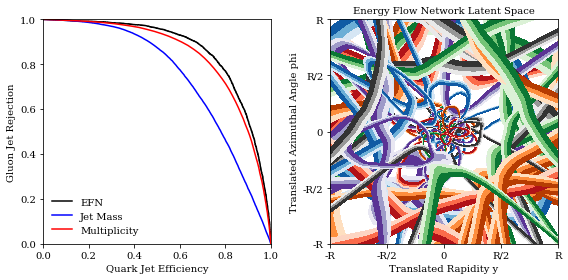

In [60]:
# some nicer plot settings 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 2, figsize=(8,4))

######################### ROC Curve Plot #########################

# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# plot the ROC curves
axes[0].plot(efn_tp, 1-efn_fp, '-', color='black', label='EFN')
axes[0].plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
axes[0].plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
axes[0].set_xlabel('Quark Jet Efficiency')
axes[0].set_ylabel('Gluon Jet Rejection')

# axes limits
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# make legend and show plot
axes[0].legend(loc='lower left', frameon=False)

######################### Filter Plot #########################

# plot settings
R, n = 0.4, 100
colors = ['Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Greys']
grads = np.linspace(0.45, 0.55, 4)

# evaluate filters
X, Y, Z = efn.eval_filters(R, n=n)

# plot filters
for i,z in enumerate(Z):
    axes[1].contourf(X, Y, z/np.max(z), grads, cmap=colors[i%len(colors)])

axes[1].set_xticks(np.linspace(-R, R, 5))
axes[1].set_yticks(np.linspace(-R, R, 5))
axes[1].set_xticklabels(['-R', '-R/2', '0', 'R/2', 'R'])
axes[1].set_yticklabels(['-R', '-R/2', '0', 'R/2', 'R'])
axes[1].set_xlabel('Translated Rapidity y')
axes[1].set_ylabel('Translated Azimuthal Angle phi')
axes[1].set_title('Energy Flow Network Latent Space', fontdict={'fontsize': 10})

plt.show()